In [1]:
using Distributions, Flux, StatsPlots, SparseArrays
using ReactionNetworks, MultifidelitySamples

### Set up simulations
The chemical reaction network example we use is a chain of $K$ enzyme kinetics modules
$$X_k + E_k \leftrightarrow C_k \rightarrow X_{k+1} + E_k$$
for $n=1,\dots,K$, where $X_{K+1}=P$ is the product molecule.
- The forward reaction $X_k + E_k \rightarrow C_k$ has rate $\alpha_k$.
- The reverse reaction $X_k + E_k \leftarrow C_k$ has rate $\alpha_{-k}$.
- The product reaction $C_k \rightarrow X_{k+1}+E_k$ has rate $\beta_k$.
The high-fidelity model is the full exact stochastic simulation algorithm of Gillespie on the entire network.

In [2]:
struct EnzymeChain{K, NS, NR} <: AbstractReactionNetwork{NS, NR}
    α₊::NTuple{K, Float64}
    α₋::NTuple{K, Float64}
    β::NTuple{K, Float64}
    function EnzymeChain(α₊::NTuple{K, Float64}, α₋::NTuple{K, Float64}, β::NTuple{K, Float64}) where K
        NS = 3*K + 1
        NR = 3*K
        return new{K, NS, NR}(α₊, α₋, β)
    end
end
function ReactionNetworks.stoichiometric_matrix(::EnzymeChain{K, NS, NR}) where {K, NS, NR}
    S = [spzeros(NS) for i in 1:NR]
    for k in 1:K
        ind_Xk = k
        ind_Xk₊₊ = k+1
        ind_Ek = K+k+1
        ind_Ck = K+K+k+1
        S[k][[ind_Xk, ind_Ek, ind_Ck]] = [-1, -1, 1]
        S[K+k][[ind_Xk, ind_Ek, ind_Ck]] = [1, 1, -1]
        S[K+K+k][[ind_Ck, ind_Ek, ind_Xk₊₊]] = [-1, 1, 1]
    end
    return S
end
function (rn::EnzymeChain{K})(v::AbstractVector{Float64}, x::AbstractVector{Int}) where K
    for k in 1:K
        v[k] = rn.α₊[k] * x[k] * x[K+k+1]
        v[K+k] = rn.α₋[k] * x[K+K+k+1]
        v[K+K+k] = rn.β[k] * x[K+K+k+1]
    end
    return nothing
end

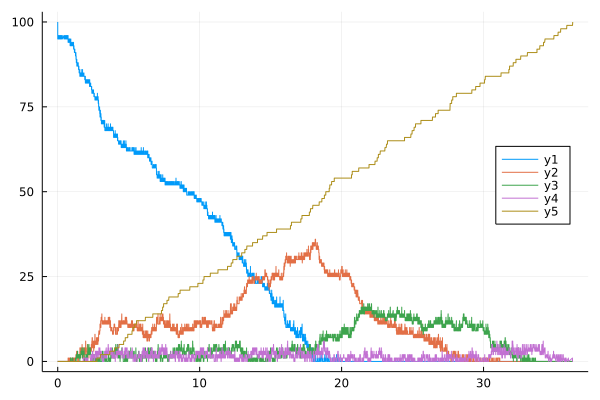

In [3]:
K = 4
HI = EnzymeChain(ntuple(x->10.0, K), ntuple(x->10.0, K), ntuple(x->1.0, K))

thi, xhi, chi = simulate(HI, [100,0,0,0,0,5,5,5,5,0,0,0,0], (0.0, 100.0))
plot(thi, permutedims(xhi[1:(K+1), :]), legend=:right)

We have $K$ low-fidelity models. The coarsest low fidelity model, $f_1$, replaces each of the $K$ enzyme kinetics modules with the single reaction
$X_k \rightarrow X_{k+1}$
with propensity $$\gamma_k X_k(t) = \frac{\beta_k \bar E_k}{K_k + X_k(t)} X_k(t),$$
for the Michaelis--Menten constants $K_k = (\alpha_{-k} + \beta_k)/\alpha_k$.
Then $f_k$ replaces the $(K-k+2)^{\mathrm{th}}$ module with the full enzyme kinetics module.

Apologies for the indexing.

We allow for coupling between high-fidelity and low-fidelity simulations. We save the underlying unit rate Poisson process of the single reaction in the low-fidelity modules. This is then reused as the unit rate Poisson process for the $C \rightarrow P + E$ reaction in the high-fidelity simulation.

In [4]:
struct EnzymeChainMM{k, K, NS, NR} <: AbstractReactionNetwork{NS, NR}
    # here k refers to the number of reduced modules. So k=K is coarsest and k=1 is the closest to hi-fidelity
    α₊::NTuple{K, Float64}
    α₋::NTuple{K, Float64}
    β::NTuple{K, Float64}
    Ē::NTuple{K, Int64}
    function EnzymeChainMM(k::Int64, α₊::NTuple{K, Float64}, α₋::NTuple{K, Float64}, β::NTuple{K, Float64}, Ē::NTuple{K, Int64}) where K
        if k==0
            return EnzymeChain(α₊, α₋, β)
        elseif 0 < k <= K
            NS = (1*k) + (3*(K-k)) + 1
            NR = (1*k) + (3*(K-k))
            return new{k, K, NS, NR}(α₊, α₋, β, Ē)
        else
            error("Blah")
        end
    end
end

function ReactionNetworks.stoichiometric_matrix(::EnzymeChainMM{k, K, NS, NR}) where {k, K, NS, NR}
    S = [spzeros(NS) for i in 1:NR]
    nFullModules = K-k
    for i in 1:k
        S[i][[i, i+1]] = [-1, 1]
    end
    for i in 1:nFullModules
        Xi_ind = k+i
        Xi₊₊_ind = k+i+1
        Ei_ind = k+nFullModules+i+1
        Ci_ind = k+nFullModules+nFullModules+i+1
        S[k+i][[Xi_ind, Ei_ind, Ci_ind]] = [-1, -1, 1]
        S[k+nFullModules+i][[Xi_ind, Ei_ind, Ci_ind]] = [1, 1, -1]
        S[k+nFullModules+nFullModules+i][[Ci_ind, Ei_ind, Xi₊₊_ind]] = [-1, 1, 1]
    end
    return S
end

function (rn::EnzymeChainMM{k, K})(v::AbstractVector{Float64}, x::AbstractVector{Int}) where {k, K}
    nFullModules = K-k
    for i in 1:k
        MM = (rn.α₋[i]+rn.β[i])/rn.α₊[i]
        v[i] = (rn.β[i] * min(x[i],rn.Ē[i]) / (MM + x[i])) * x[i]
    end
    for i in 1:nFullModules
        Xi_ind = k+i
        Xi₊₊_ind = k+i+1
        Ei_ind = k+nFullModules+i+1
        Ci_ind = k+nFullModules+nFullModules+i+1
        v[k+i] = rn.α₊[k+i] * x[Xi_ind] * x[Ei_ind]
        v[k+nFullModules+i] = rn.α₋[k+i] * x[Ci_ind]
        v[k+nFullModules+nFullModules+i] = rn.β[k+i] * x[Ci_ind]
    end
    return nothing
end

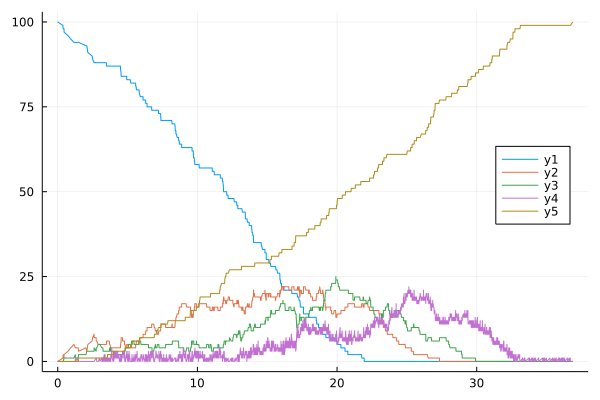

In [5]:
LO = EnzymeChainMM(3, ntuple(x->10.0, K), ntuple(x->10.0, K), ntuple(x->1.0, K), ntuple(x->5, K))

tlo, xlo, clo = simulate(LO, [100,0,0,0,0,5,0], (0.0, 100.0))
plot(tlo, permutedims(xlo[1:K+1,:]), legend=:right)

Now try coupling! Take a low-fidelity simulation and produce the next simulation along.

In [6]:
LO_all = [EnzymeChainMM(k, ntuple(x->10.0, K), ntuple(x->10.0, K), ntuple(x->1.0, K), ntuple(x->5, K)) for k in K:-1:1]

4-element Vector{EnzymeChainMM{k, 4} where k}:
 EnzymeChainMM{4, 4, 5, 4}((10.0, 10.0, 10.0, 10.0), (10.0, 10.0, 10.0, 10.0), (1.0, 1.0, 1.0, 1.0), (5, 5, 5, 5))
 EnzymeChainMM{3, 4, 7, 6}((10.0, 10.0, 10.0, 10.0), (10.0, 10.0, 10.0, 10.0), (1.0, 1.0, 1.0, 1.0), (5, 5, 5, 5))
 EnzymeChainMM{2, 4, 9, 8}((10.0, 10.0, 10.0, 10.0), (10.0, 10.0, 10.0, 10.0), (1.0, 1.0, 1.0, 1.0), (5, 5, 5, 5))
 EnzymeChainMM{1, 4, 11, 10}((10.0, 10.0, 10.0, 10.0), (10.0, 10.0, 10.0, 10.0), (1.0, 1.0, 1.0, 1.0), (5, 5, 5, 5))

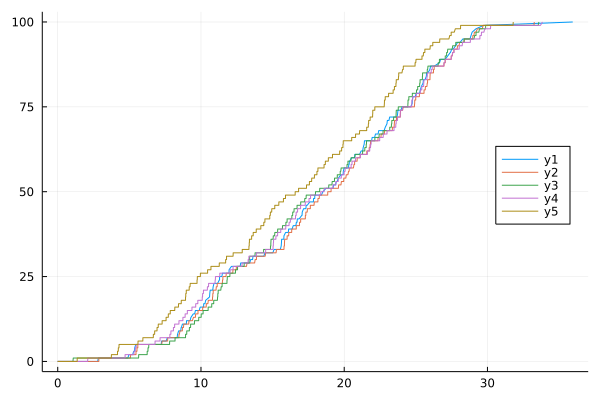

In [7]:
t1,x1,c1 = simulate(LO_all[1], [100, 0, 0, 0, 0], (0.0, 100.0));

t2,x2,c2 = simulate(LO_all[2], [100,0,0,0,0,5,0], (0.0, 100.0), (
        c1[1], 
        c1[2], 
        c1[3], 
        nothing, nothing, c1[4],
    ));

t3,x3,c3 = simulate(LO_all[3], [100,0,0,0,0,5,5,0,0], (0.0, 100.0), (
        c2[1], 
        c2[2], 
        nothing, nothing, c2[3], 
        c2[4], c2[5], c2[6],
    ));

t4,x4,c4 = simulate(LO_all[4], [100,0,0,0,0,5,5,5,0,0,0], (0.0, 100.0), (
        c3[1],
        nothing, nothing, c3[2],
        c3[3], c3[4], c3[5],
        c3[6], c3[7], c3[8],
    ));

t5,x5,c5 = simulate(HI, [100,0,0,0,0,5,5,5,5,0,0,0,0], (0.0, 100.0), (
        nothing, nothing, c4[1],
        c4[2], c4[3], c4[4],
        c4[5], c4[6], c4[7],
        c4[8], c4[9], c4[10],
    ));

plot(t1,x1[5,:], legend=:right)
plot!(t2,x2[5,:])
plot!(t3,x3[5,:])
plot!(t4,x4[5,:])
plot!(t5,x5[5,:])

In [8]:
ReactionChannels

Tuple{Vararg{Union{Nothing, ReactionNetworks.ReactionChannel}, M}} where M

# Set up likelihoods
Now we can use `MultifidelitySamples` with the models defined above.
Below, it's the coupling that provides the most pain, but that's a consequence of some suboptimal coding.

In [9]:
struct EnzymeLikelihood{T} <: AbstractSimulationBasedLikelihood
    k::Int64 # number of reduced modules
    K::Int64 # number of modules
    flag_inΩ::T # take summary statistics and ask if within Ω
end

struct FinishTimes <: AbstractSummaryInformation
    T::Vector{Float64}
    function FinishTimes(t, x)
        y = t[[1+findlast(>(0), x_i) for x_i in eachrow(x)]]
        return new(y)
    end
end

using StaticArrays
MaybeChannel = Union{Nothing, ReactionNetworks.ReactionChannel}
struct CouplingMatrix{K} <: AbstractSimulationData
    c::SizedArray{Tuple{K,3}, MaybeChannel}
    function CouplingMatrix(c::AbstractArray{MaybeChannel})
        K = size(c, 1)
        return new{K}(c)
    end
    function CouplingMatrix{K}() where K
        return new{K}(fill(nothing, (K,3)))
    end
end

function CouplingMatrix(K, k, c::ReactionChannels)
    cmat = CouplingMatrix{K}()
    i = 1
    for _k in 1:k
        cmat.c[_k, 3] = c[i]
        i += 1
    end
    for _k in (k+1):K
        for _r in 1:3
            cmat.c[_k, _r] = c[i]
            i += 1
        end
    end
    return cmat
end

function ReactionChannels(cmat::CouplingMatrix{K}, k::Int64) where K
    t_a = tuple((cmat.c[_k, 3] for _k in 1:k)...)
    t_b = tuple((cmat.c[_k, _r] for _k in (k+1):K for _r in 1:3)...)
    return tuple(t_a..., t_b...)
end

function MultifidelitySamples._evaluate(L::EnzymeLikelihood, θ=(10.0, 10.0, 1.0), ξ::CouplingMatrix=CouplingMatrix{L.K}())
    
    numRedModules = L.k
    numFullModules = (L.K - L.k)
    
    model = EnzymeChainMM(L.k, ntuple(x->θ[1], L.K), ntuple(x->θ[2], L.K), ntuple(x->θ[3], L.K), ntuple(x->5, L.K))
    x0 = spzeros(Int64, 1 + numRedModules + 3*numFullModules)
    x0[1] = 100
    x0[(L.K+1+1):(L.K+1+numFullModules)] .= 5
    
    t, x, c = simulate(model, x0, (0.0, 100.0), ReactionChannels(ξ, L.k))
    
    y = FinishTimes(t, x[1:L.K, :])
    cmat = CouplingMatrix(L.K, L.k, c)

    return float(flag_inΩ(y.T)), y, cmat
end

In [10]:
using Distances
data = [23.,27.,29.,31.]
flag_inΩ = y -> (sqeuclidean(y, data) < 9.0)
L(k) = EnzymeLikelihood(k, 4, flag_inΩ)

L (generic function with 1 method)

## Multifidelity Samples
Below, we combine multiple simulation-based likelihoods into a single multifidelity likelihood.
A tree is constructed and the multifidelity likelihood can be evaluated.
On average, it's positive but there is a non-zero probability that any one multifidelity likelihood evaluation returns a negative number.

In [11]:
L_mf = MultifidelityPathLikelihood(L(0), L(4), L(3), L(2), L(1))

MultifidelityPathLikelihood:
L_{lo, 1}: EnzymeLikelihood{var"#45#46"}(4, 4, var"#45#46"())
L_{lo, 2}: EnzymeLikelihood{var"#45#46"}(3, 4, var"#45#46"())
L_{lo, 3}: EnzymeLikelihood{var"#45#46"}(2, 4, var"#45#46"())
L_{lo, 4}: EnzymeLikelihood{var"#45#46"}(1, 4, var"#45#46"())
L_hi: EnzymeLikelihood{var"#45#46"}(0, 4, var"#45#46"())

In [12]:
omegas = map(1:1000) do _
    T = MultifidelityPathTree(L_mf, 0.0, (10.0, 10.0, 1.0), 0.1)
    MultifidelitySamples.evaluate(T)
end

1000-element Vector{Float64}:
  1.0
  3.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
 -3.0
  0.0
 -1.0
  0.0
  0.0
  ⋮
  1.0
  0.0
  1.0
  0.0
  1.0
  0.0
  1.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [13]:
mean(omegas)

0.188